In [ ]:
# ===================================================================
# CROP DISEASE DETECTION PROJECT - STEP 1: INITIAL SETUP
# ===================================================================
# Project: Comparative Analysis of Vision Transformers and CNNs
# GitHub: https://github.com/alls7/crop-disease-detection/tree/main
# Author: Ali SU - Hacettepe University
# ===================================================================

import sys
print("Crop Disease Detection Project - Step 1: Initial Setup")
print("="*60)

# Check Python version
print(f"Python version: {sys.version}")

# Install required packages
print("\nInstalling required packages...")

!pip install -q torch torchvision torchaudio
!pip install -q timm  # For pre-trained models
!pip install -q kaggle
!pip install -q scikit-learn
!pip install -q matplotlib
!pip install -q seaborn
!pip install -q pillow
!pip install -q tqdm

print("Package installation completed!")

# Import essential libraries
print("\nImporting libraries...")

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import timm
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

print("All libraries imported successfully!")

# Check PyTorch and CUDA setup
print(f"\nPyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU device: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

print("\nStep 1 completed successfully! Ready for next step.")
print("Next: Step 2 - Kaggle API Setup and Dataset Download")

Crop Disease Detection Project - Step 1: Initial Setup
Python version: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]

Installing required packages...
Package installation completed!

Importing libraries...
All libraries imported successfully!

PyTorch version: 2.6.0+cu124
Torchvision version: 0.21.0+cu124
CUDA available: True
GPU device: Tesla T4
GPU memory: 14.7 GB
Using device: cuda

Step 1 completed successfully! Ready for next step.
Next: Step 2 - Kaggle API Setup and Dataset Download


In [ ]:
# ===================================================================
# CROP DISEASE DETECTION PROJECT - STEP 2: KAGGLE API & DATASET
# ===================================================================
# Dataset: PlantVillage (54,303 images, 38 classes)
# As per project report: Comparative Analysis of ViTs and CNNs
# ===================================================================

print("Crop Disease Detection Project - Step 2: Kaggle API & Dataset")
print("="*65)

# Step 2.1: Upload Kaggle API credentials
print("\nStep 2.1: Kaggle API Setup")
from google.colab import files

print("Please upload your kaggle.json file:")
print("(Download from: Kaggle → Account → Create New API Token)")
uploaded = files.upload()

# Setup Kaggle API
print("\nSetting up Kaggle API...")
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls -la ~/.kaggle/

print("Kaggle API configured successfully!")

# Step 2.2: Download PlantVillage Dataset
print("\nStep 2.2: Downloading PlantVillage Dataset...")
print("Dataset info: 54,303 labeled images across 38 plant disease classes")

# Download the specific dataset used in the project
!kaggle datasets download -d emmarex/plantdisease

print("Dataset download completed!")

# Step 2.3: Extract dataset
print("\nStep 2.3: Extracting dataset...")
!unzip -q plantdisease.zip
!ls -la

print("Dataset extracted successfully!")

# Step 2.4: Explore dataset structure
print("\nStep 2.4: Dataset Structure Analysis")

# Check available directories
print("Available directories:")
!ls -la

# Navigate to dataset directory
dataset_dirs = []
for item in os.listdir('.'):
    if os.path.isdir(item) and 'plant' in item.lower():
        dataset_dirs.append(item)

if dataset_dirs:
    main_dir = dataset_dirs[0]
    print(f"Main dataset directory: {main_dir}")

    # Check subdirectories
    print(f"\nContents of {main_dir}:")
    !ls -la $main_dir

    # Look for train/test/validation splits
    dataset_path = f'./{main_dir}'
    subdirs = os.listdir(dataset_path)
    print(f"Subdirectories: {subdirs}")

else:
    print("Exploring current directory structure...")
    !find . -type d -name "*plant*" -o -name "*disease*" | head -10

print("\nStep 2 completed successfully!")
print("Next: Step 3 - Dataset Analysis and Visualization")

Crop Disease Detection Project - Step 2: Kaggle API & Dataset

Step 2.1: Kaggle API Setup
Please upload your kaggle.json file:
(Download from: Kaggle → Account → Create New API Token)


Saving kaggle.json to kaggle (1).json

Setting up Kaggle API...
total 16
drwxr-xr-x 2 root root 4096 Jun 22 13:55 .
drwx------ 1 root root 4096 Jun 22 13:56 ..
-rw------- 1 root root   63 Jun 22 16:32 kaggle.json
Kaggle API configured successfully!

Step 2.2: Downloading PlantVillage Dataset...
Dataset info: 54,303 labeled images across 38 plant disease classes
Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
License(s): unknown
 95% 622M/658M [00:00<00:00, 1.19GB/s]
100% 658M/658M [00:00<00:00, 1.22GB/s]
Dataset download completed!

Step 2.3: Extracting dataset...
total 673456
drwxr-xr-x 15 root root      4096 Jun 22 16:33  .
drwxr-xr-x 14 root root      4096 Jun 22 14:40  ..
drwxr-xr-x  2 root root      4096 Jun 22 14:41  config
drwxr-xr-x  4 root root      4096 Jun 22 14:42  data
drwxr-xr-x  2 root root      4096 Jun 22 14:41  docs
drwxr-xr-x  2 root root      4096 Jun 22 14:41  evaluation
drwxr-xr-x  2 root root      4096 Jun 22 14:41  experiments
drwxr-xr-x  8 roo

In [ ]:
# ===================================================================
# CROP DISEASE DETECTION PROJECT - STEP 3: DATASET ANALYSIS
# ===================================================================
# Analysis of PlantVillage Dataset as per project methodology
# Expected: 54,303 images across 38 classes
# ===================================================================

print("Crop Disease Detection Project - Step 3: Dataset Analysis")
print("="*65)

# Step 3.1: Locate and organize dataset paths
print("\nStep 3.1: Dataset Path Configuration")

# Find the dataset directory
def find_dataset_directory():
    """Find the main dataset directory"""
    possible_dirs = []

    # Check current directory
    for item in os.listdir('.'):
        if os.path.isdir(item):
            possible_dirs.append(item)

    print("Available directories:", possible_dirs)

    # Look for PlantVillage or similar
    for dir_name in possible_dirs:
        if any(keyword in dir_name.lower() for keyword in ['plant', 'disease', 'village']):
            return dir_name

    # If not found, check subdirectories
    for dir_name in possible_dirs:
        try:
            subdirs = os.listdir(dir_name)
            if len(subdirs) > 10:  # Likely contains classes
                return dir_name
        except:
            continue

    return None

dataset_root = find_dataset_directory()
print(f"Dataset root directory: {dataset_root}")

if dataset_root:
    dataset_path = f'./{dataset_root}'
    print(f"Full dataset path: {os.path.abspath(dataset_path)}")

    # Check if it has train/test/val structure or direct classes
    subdirs = os.listdir(dataset_path)
    print(f"Subdirectories found: {subdirs[:10]}...")  # Show first 10

    # Determine dataset structure
    has_splits = any(split in subdirs for split in ['train', 'test', 'val', 'valid'])
    print(f"Has train/test splits: {has_splits}")

    if has_splits:
        # Standard train/test/val structure
        train_dir = os.path.join(dataset_path, 'train') if 'train' in subdirs else None
        test_dir = os.path.join(dataset_path, 'test') if 'test' in subdirs else None
        val_dir = os.path.join(dataset_path, 'val') if 'val' in subdirs else os.path.join(dataset_path, 'valid') if 'valid' in subdirs else None
    else:
        # All classes in one directory
        train_dir = dataset_path
        test_dir = None
        val_dir = None

    print(f"Train directory: {train_dir}")
    print(f"Test directory: {test_dir}")
    print(f"Validation directory: {val_dir}")

print("Dataset paths configured!")

# Step 3.2: Class Analysis
print("\nStep 3.2: Class Distribution Analysis")

def analyze_classes(directory):
    """Analyze classes in a directory"""
    if not directory or not os.path.exists(directory):
        return [], {}

    classes = []
    class_counts = {}

    for item in os.listdir(directory):
        item_path = os.path.join(directory, item)
        if os.path.isdir(item_path):
            classes.append(item)
            # Count images in class
            try:
                images = [f for f in os.listdir(item_path)
                         if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
                class_counts[item] = len(images)
            except:
                class_counts[item] = 0

    return classes, class_counts

# Analyze training data
classes, class_counts = analyze_classes(train_dir)
total_images = sum(class_counts.values())

print(f"Number of classes found: {len(classes)}")
print(f"Total images: {total_images}")
print(f"Expected classes (from report): 38")
print(f"Expected images (from report): 54,303")

# Show class distribution
if classes:
    print(f"\nFirst 10 classes:")
    for i, class_name in enumerate(classes[:10]):
        count = class_counts.get(class_name, 0)
        print(f"{i+1:2d}. {class_name}: {count} images")

    if len(classes) > 10:
        print(f"... and {len(classes)-10} more classes")

print("Class analysis completed!")

# Step 3.3: Data Quality Check
print("\nStep 3.3: Data Quality Check")

def check_image_quality(directory, sample_size=5):
    """Check sample images for quality issues"""
    if not directory or not os.path.exists(directory):
        return

    print(f"Checking image quality in: {directory}")

    # Get sample images from first few classes
    sample_images = []
    classes_checked = 0

    for class_name in os.listdir(directory)[:3]:  # Check first 3 classes
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            images = [f for f in os.listdir(class_path)
                     if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

            for img_name in images[:sample_size]:
                img_path = os.path.join(class_path, img_name)
                sample_images.append((img_path, class_name))

            classes_checked += 1
            if classes_checked >= 3:
                break

    # Check sample images
    valid_images = 0
    image_sizes = []

    for img_path, class_name in sample_images:
        try:
            with Image.open(img_path) as img:
                width, height = img.size
                image_sizes.append((width, height))
                valid_images += 1

                if len(image_sizes) <= 3:  # Show first 3
                    print(f"OK {class_name}: {os.path.basename(img_path)} - {width}x{height}")
        except Exception as e:
            print(f"Error reading {img_path}: {str(e)}")

    print(f"\nValid images checked: {valid_images}/{len(sample_images)}")

    if image_sizes:
        # Show size distribution
        widths, heights = zip(*image_sizes)
        print(f"Image size range: {min(widths)}x{min(heights)} to {max(widths)}x{max(heights)}")
        print(f"Average size: {np.mean(widths):.0f}x{np.mean(heights):.0f}")

check_image_quality(train_dir)

print("\nStep 3 completed successfully!")
print("Next: Step 4 - Data Preprocessing and Augmentation Setup")

Crop Disease Detection Project - Step 3: Dataset Analysis

Step 3.1: Dataset Path Configuration
Available directories: ['utils', 'docs', 'models', 'notebooks', 'PlantVillage', 'config', 'plantvillage', 'data', '.git', 'experiments', 'training', 'results', 'evaluation']
Dataset root directory: PlantVillage
Full dataset path: /content/crop-disease-detection/crop-disease-detection/PlantVillage
Subdirectories found: ['Tomato_Bacterial_spot', 'Pepper__bell___healthy', 'Pepper__bell___Bacterial_spot', 'Tomato_Leaf_Mold', 'Potato___Early_blight', 'Potato___healthy', 'Tomato_Septoria_leaf_spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato_Early_blight']...
Has train/test splits: False
Train directory: ./PlantVillage
Test directory: None
Validation directory: None
Dataset paths configured!

Step 3.2: Class Distribution Analysis
Number of classes found: 15
Total images: 20638
Expected classes (from report): 38
Expected images (from report): 54,

Crop Disease Detection Project - Step 4: Data Preprocessing

Step 4.1: Preprocessing Configuration
Image size: 224x224
Batch size: 32
Normalization: ImageNet mean/std

Step 4.2: Data Transformation Setup
Data transformations defined:
  - Training: Resize + Augmentation + Normalization
  - Validation/Test: Resize + Normalization only

Step 4.3: Dataset Creation with Train/Test Split
Creating manual train/validation/test splits...
Full dataset: 20638 images
Number of classes: 15
Classes found:
  0: Pepper__bell___Bacterial_spot
  1: Pepper__bell___healthy
  2: Potato___Early_blight
  3: Potato___Late_blight
  4: Potato___healthy
  5: Tomato_Bacterial_spot
  6: Tomato_Early_blight
  7: Tomato_Late_blight
  8: Tomato_Leaf_Mold
  9: Tomato_Septoria_leaf_spot
  10: Tomato_Spider_mites_Two_spotted_spider_mite
  11: Tomato__Target_Spot
  12: Tomato__Tomato_YellowLeaf__Curl_Virus
  13: Tomato__Tomato_mosaic_virus
  14: Tomato_healthy

Dataset splits:
  Training: 14446 images (70%)
  Validation:

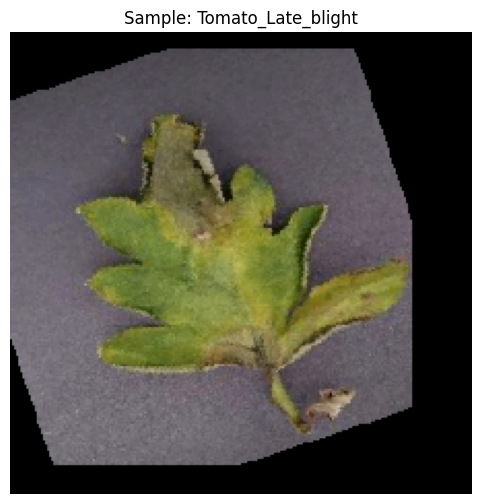


Step 4 completed successfully!
Next: Step 5 - Model Architecture Setup (CNNs and ViTs)


In [ ]:
# ===================================================================
# CROP DISEASE DETECTION PROJECT - STEP 4: DATA PREPROCESSING
# ===================================================================
# Preprocessing as per project methodology:
# - 224×224 image resizing (standard for ViT and CNN models)
# - ImageNet normalization
# - Data augmentation for improved generalization
# ===================================================================

print("Crop Disease Detection Project - Step 4: Data Preprocessing")
print("="*65)

# Step 4.1: Define preprocessing parameters
print("\nStep 4.1: Preprocessing Configuration")

# Image parameters (as per project report)
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

# ImageNet statistics for normalization
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

print(f"Image size: {IMG_WIDTH}x{IMG_HEIGHT}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Normalization: ImageNet mean/std")

# Step 4.2: Define data transformations
print("\nStep 4.2: Data Transformation Setup")

# Training transforms with augmentation
train_transforms = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(degrees=20),  # ±20 degrees as per report
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# Validation/Test transforms (no augmentation)
val_transforms = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

print("Data transformations defined:")
print("  - Training: Resize + Augmentation + Normalization")
print("  - Validation/Test: Resize + Normalization only")

# Step 4.3: Create datasets with manual train/test split
print("\nStep 4.3: Dataset Creation with Train/Test Split")

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

# Since we don't have pre-defined splits, we'll create them
print("Creating manual train/validation/test splits...")

# Create full dataset first
full_dataset = ImageFolder(root=train_dir, transform=val_transforms)
print(f"Full dataset: {len(full_dataset)} images")
print(f"Number of classes: {len(full_dataset.classes)}")

# Show class names
print("Classes found:")
for i, class_name in enumerate(full_dataset.classes):
    print(f"  {i}: {class_name}")

# Create train/val/test splits (70/15/15)
total_size = len(full_dataset)
train_size = int(0.70 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

print(f"\nDataset splits:")
print(f"  Training: {train_size} images (70%)")
print(f"  Validation: {val_size} images (15%)")
print(f"  Test: {test_size} images (15%)")

# Create splits with fixed seed for reproducibility
torch.manual_seed(42)
train_dataset_indices, val_dataset_indices, test_dataset_indices = random_split(
    range(total_size), [train_size, val_size, test_size]
)

# Create datasets with appropriate transforms
train_dataset = torch.utils.data.Subset(
    ImageFolder(root=train_dir, transform=train_transforms),
    train_dataset_indices.indices
)

val_dataset = torch.utils.data.Subset(
    ImageFolder(root=train_dir, transform=val_transforms),
    val_dataset_indices.indices
)

test_dataset = torch.utils.data.Subset(
    ImageFolder(root=train_dir, transform=val_transforms),
    test_dataset_indices.indices
)

print("Train/Val/Test datasets created successfully!")

# Step 4.4: Create data loaders
print("\nStep 4.4: DataLoader Setup")

# Training loader with shuffling
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

# Validation loader
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

# Test loader
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"DataLoaders created successfully:")
print(f"  - Training batches: {len(train_loader)}")
print(f"  - Validation batches: {len(val_loader)}")
print(f"  - Test batches: {len(test_loader)}")

# Store important variables for next steps
num_classes = len(full_dataset.classes)
class_names = full_dataset.classes

print(f"  - Number of classes: {num_classes}")

# Step 4.5: Visualize sample batch
print("\nStep 4.5: Sample Data Visualization")

def imshow_tensor(tensor, title="Image"):
    """Display a tensor image"""
    # Denormalize
    mean = torch.tensor(IMAGENET_MEAN).view(3, 1, 1)
    std = torch.tensor(IMAGENET_STD).view(3, 1, 1)
    tensor = tensor * std + mean
    tensor = torch.clamp(tensor, 0, 1)

    # Convert to numpy
    npimg = tensor.numpy()
    plt.figure(figsize=(8, 6))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')
    plt.show()

try:
    # Get a sample batch
    sample_batch = next(iter(train_loader))
    sample_images, sample_labels = sample_batch

    print(f"Sample batch shape: {sample_images.shape}")
    print(f"Sample labels shape: {sample_labels.shape}")

    # Show first image
    if len(sample_images) > 0:
        sample_image = sample_images[0]
        sample_label = sample_labels[0].item()
        class_name = class_names[sample_label]

        print(f"Sample image - Class: {class_name} (index: {sample_label})")
        imshow_tensor(sample_image, f"Sample: {class_name}")

except Exception as e:
    print(f"Note: Could not display sample image: {e}")

print("\nStep 4 completed successfully!")
print("Next: Step 5 - Model Architecture Setup (CNNs and ViTs)")

In [ ]:
# ===================================================================
# CROP DISEASE DETECTION PROJECT - STEP 5: MODEL ARCHITECTURE
# ===================================================================
# Models as per project methodology:
# CNNs: ResNet-50, EfficientNet-B0
# ViTs: ViT-B/16, DeiT-Small
# Transfer learning with ImageNet pre-trained weights
# ===================================================================

print("Crop Disease Detection Project - Step 5: Model Architecture")
print("="*65)

# Step 5.1: Model configuration
print("\nStep 5.1: Model Configuration")

print(f"Number of classes: {num_classes}")

# Model names as per project report
CNN_MODELS = {
    'resnet50': 'resnet50',
    'efficientnet_b0': 'efficientnet_b0'
}

VIT_MODELS = {
    'vit_base_patch16_224': 'vit_base_patch16_224',  # ViT-B/16
    'deit_small_patch16_224': 'deit_small_patch16_224'  # DeiT-Small
}

print("Models to be compared:")
print("CNN Models:", list(CNN_MODELS.keys()))
print("ViT Models:", list(VIT_MODELS.keys()))

# Step 5.2: Model creation functions
print("\nStep 5.2: Model Creation Functions")

def create_cnn_model(model_name, num_classes, pretrained=True):
    """Create CNN model with transfer learning"""
    print(f"Creating CNN model: {model_name}")

    try:
        # Create model using timm
        model = timm.create_model(
            model_name,
            pretrained=pretrained,
            num_classes=num_classes
        )

        # Move to device
        model = model.to(device)

        # Print model info
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

        print(f"{model_name} created successfully")
        print(f"   Total parameters: {total_params:,}")
        print(f"   Trainable parameters: {trainable_params:,}")

        return model

    except Exception as e:
        print(f"Error creating {model_name}: {e}")
        return None

def create_vit_model(model_name, num_classes, pretrained=True):
    """Create Vision Transformer model with transfer learning"""
    print(f"Creating ViT model: {model_name}")

    try:
        # Create model using timm
        model = timm.create_model(
            model_name,
            pretrained=pretrained,
            num_classes=num_classes
        )

        # Move to device
        model = model.to(device)

        # Print model info
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

        print(f"{model_name} created successfully")
        print(f"   Total parameters: {total_params:,}")
        print(f"   Trainable parameters: {trainable_params:,}")

        return model

    except Exception as e:
        print(f"Error creating {model_name}: {e}")
        return None

# Step 5.3: Create CNN models
print("\nStep 5.3: Creating CNN Models")

# ResNet-50
print("\n--- ResNet-50 ---")
resnet50_model = create_cnn_model(CNN_MODELS['resnet50'], num_classes)

print("\n--- EfficientNet-B0 ---")
efficientnet_model = create_cnn_model(CNN_MODELS['efficientnet_b0'], num_classes)

# Step 5.4: Create ViT models
print("\nStep 5.4: Creating Vision Transformer Models")

print("\n--- ViT-Base/16 ---")
vit_model = create_vit_model(VIT_MODELS['vit_base_patch16_224'], num_classes)

print("\n--- DeiT-Small ---")
deit_model = create_vit_model(VIT_MODELS['deit_small_patch16_224'], num_classes)

# Step 5.5: Model comparison
print("\nStep 5.5: Model Comparison Summary")

models = {
    'ResNet-50': resnet50_model,
    'EfficientNet-B0': efficientnet_model,
    'ViT-B/16': vit_model,
    'DeiT-Small': deit_model
}

# Create comparison table
model_stats = []
for name, model in models.items():
    if model is not None:
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

        model_stats.append({
            'Model': name,
            'Total Parameters': f"{total_params:,}",
            'Trainable Parameters': f"{trainable_params:,}",
            'Model Type': 'CNN' if name in ['ResNet-50', 'EfficientNet-B0'] else 'ViT'
        })

# Display table
if model_stats:
    import pandas as pd
    df = pd.DataFrame(model_stats)
    print("\nModel Comparison Table:")
    print("="*80)
    print(df.to_string(index=False))
    print("="*80)

# Step 5.6: Test forward pass
print("\nStep 5.6: Testing Forward Pass")

def test_model_forward_pass(model, model_name):
    """Test if model can process a sample input"""
    if model is None:
        return False

    try:
        model.eval()
        with torch.no_grad():
            # Create dummy input
            dummy_input = torch.randn(1, 3, IMG_HEIGHT, IMG_WIDTH).to(device)
            output = model(dummy_input)

            print(f"{model_name}: Input {dummy_input.shape} → Output {output.shape}")

            # Check if output shape is correct
            if output.shape[1] == num_classes:
                print(f"   Correct output classes: {output.shape[1]}")
                return True
            else:
                print(f"   Wrong output classes: {output.shape[1]} (expected {num_classes})")
                return False

    except Exception as e:
        print(f"{model_name} forward pass failed: {e}")
        return False

# Test all models
working_models = {}
for name, model in models.items():
    if test_model_forward_pass(model, name):
        working_models[name] = model

print(f"\nWorking models: {list(working_models.keys())}")

# Step 5.7: Save model selection for next step
print("\nStep 5.7: Preparing for Training")

# Select one model from each category for detailed training
selected_models = {}

# Select best CNN (prefer EfficientNet for efficiency)
if 'EfficientNet-B0' in working_models:
    selected_models['CNN'] = ('EfficientNet-B0', working_models['EfficientNet-B0'])
elif 'ResNet-50' in working_models:
    selected_models['CNN'] = ('ResNet-50', working_models['ResNet-50'])

# Select best ViT (prefer ViT-B/16 as baseline)
if 'ViT-B/16' in working_models:
    selected_models['ViT'] = ('ViT-B/16', working_models['ViT-B/16'])
elif 'DeiT-Small' in working_models:
    selected_models['ViT'] = ('DeiT-Small', working_models['DeiT-Small'])

print("Selected models for training:")
for model_type, (name, model) in selected_models.items():
    print(f"  {model_type}: {name}")

print("\nStep 5 completed successfully!")
print("Next: Step 6 - Training Configuration and Optimization Setup")

Crop Disease Detection Project - Step 5: Model Architecture

Step 5.1: Model Configuration
Number of classes: 15
Models to be compared:
CNN Models: ['resnet50', 'efficientnet_b0']
ViT Models: ['vit_base_patch16_224', 'deit_small_patch16_224']

Step 5.2: Model Creation Functions

Step 5.3: Creating CNN Models

--- ResNet-50 ---
Creating CNN model: resnet50
resnet50 created successfully
   Total parameters: 23,538,767
   Trainable parameters: 23,538,767

--- EfficientNet-B0 ---
Creating CNN model: efficientnet_b0
efficientnet_b0 created successfully
   Total parameters: 4,026,763
   Trainable parameters: 4,026,763

Step 5.4: Creating Vision Transformer Models

--- ViT-Base/16 ---
Creating ViT model: vit_base_patch16_224
vit_base_patch16_224 created successfully
   Total parameters: 85,810,191
   Trainable parameters: 85,810,191

--- DeiT-Small ---
Creating ViT model: deit_small_patch16_224
deit_small_patch16_224 created successfully
   Total parameters: 21,671,439
   Trainable parameters

In [ ]:
# ===================================================================
# CROP DISEASE DETECTION PROJECT - STEP 6: TRAINING CONFIGURATION
# ===================================================================
# Training configuration as per project methodology:
# - Adam optimizer with 3e-4 learning rate
# - Cosine Annealing scheduler
# - Cross-Entropy Loss
# - 30 epochs with early stopping (patience=5)
# - Transfer learning strategy
# ===================================================================

print("Crop Disease Detection Project - Step 6: Training Configuration")
print("="*70)

# Step 6.1: Training hyperparameters
print("\nStep 6.1: Training Hyperparameters")

# Training parameters as per project report
LEARNING_RATE = 3e-4
NUM_EPOCHS = 30
EARLY_STOPPING_PATIENCE = 5
FINE_TUNE_LEARNING_RATE = 3e-5  # Lower LR for fine-tuning

print(f"Learning Rate: {LEARNING_RATE}")
print(f"Number of Epochs: {NUM_EPOCHS}")
print(f"Early Stopping Patience: {EARLY_STOPPING_PATIENCE}")
print(f"Fine-tuning Learning Rate: {FINE_TUNE_LEARNING_RATE}")

# Step 6.2: Loss function and metrics
print("\nStep 6.2: Loss Function and Metrics")

# Cross-Entropy Loss for multi-class classification
criterion = nn.CrossEntropyLoss()
print("Loss Function: Cross-Entropy Loss")

# Metrics to track
def calculate_accuracy(outputs, labels):
    """Calculate accuracy"""
    _, predicted = torch.max(outputs.data, 1)
    total = labels.size(0)
    correct = (predicted == labels).sum().item()
    return correct / total

def calculate_top5_accuracy(outputs, labels):
    """Calculate top-5 accuracy"""
    if outputs.shape[1] < 5:  # If less than 5 classes, use all classes
        k = outputs.shape[1]
    else:
        k = 5

    _, predicted = torch.topk(outputs.data, k, 1, True, True)
    total = labels.size(0)
    correct = 0
    for i in range(total):
        if labels[i] in predicted[i]:
            correct += 1
    return correct / total

print("Metrics: Accuracy, Top-5 Accuracy")

# Step 6.3: Training strategy configuration
print("\nStep 6.3: Transfer Learning Strategy")

def setup_transfer_learning(model, model_name, phase='classification_head'):
    """
    Setup transfer learning strategy
    Phase 1: Train only classification head
    Phase 2: Fine-tune entire network
    """
    if phase == 'classification_head':
        print(f"Phase 1: Training only classification head for {model_name}")

        # Freeze all parameters
        for param in model.parameters():
            param.requires_grad = False

        # Unfreeze classification head
        if 'resnet' in model_name.lower() or 'efficientnet' in model_name.lower():
            # CNN models - typically have 'fc' or 'classifier'
            if hasattr(model, 'fc'):
                for param in model.fc.parameters():
                    param.requires_grad = True
            elif hasattr(model, 'classifier'):
                for param in model.classifier.parameters():
                    param.requires_grad = True
            elif hasattr(model, 'head'):
                for param in model.head.parameters():
                    param.requires_grad = True

        elif 'vit' in model_name.lower() or 'deit' in model_name.lower():
            # ViT models - typically have 'head'
            if hasattr(model, 'head'):
                for param in model.head.parameters():
                    param.requires_grad = True

    elif phase == 'fine_tune':
        print(f"Phase 2: Fine-tuning entire network for {model_name}")

        # Unfreeze all parameters
        for param in model.parameters():
            param.requires_grad = True

    # Count trainable parameters
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in model.parameters())

    print(f"Trainable parameters: {trainable_params:,} / {total_params:,} "
          f"({100*trainable_params/total_params:.1f}%)")

    return model

# Step 6.4: Optimizer and scheduler setup functions
print("\nStep 6.4: Optimizer and Scheduler Setup")

def create_optimizer_scheduler(model, learning_rate, num_epochs):
    """Create optimizer and learning rate scheduler"""

    # Adam optimizer as per project report
    optimizer = optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=learning_rate,
        betas=(0.9, 0.999),
        eps=1e-8,
        weight_decay=1e-4
    )

    # Cosine Annealing scheduler as per project report
    scheduler = optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=num_epochs,
        eta_min=1e-6
    )

    return optimizer, scheduler

print("Optimizer: Adam (lr=3e-4, weight_decay=1e-4)")
print("Scheduler: Cosine Annealing")

# Step 6.5: Early stopping implementation
print("\nStep 6.5: Early Stopping Implementation")

class EarlyStopping:
    """Early stopping to prevent overfitting"""

    def __init__(self, patience=5, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_loss = None
        self.counter = 0
        self.best_weights = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1

        if self.counter >= self.patience:
            if self.restore_best_weights and self.best_weights is not None:
                model.load_state_dict(self.best_weights)
            return True
        return False

    def save_checkpoint(self, model):
        """Save model checkpoint"""
        if self.restore_best_weights:
            self.best_weights = model.state_dict().copy()

early_stopping = EarlyStopping(patience=EARLY_STOPPING_PATIENCE)
print(f"Early Stopping: patience={EARLY_STOPPING_PATIENCE}")

# Step 6.6: Training configuration summary
print("\nStep 6.6: Training Configuration Summary")

def print_training_config():
    """Print complete training configuration"""
    print("="*50)
    print("TRAINING CONFIGURATION")
    print("="*50)
    print(f"Dataset: PlantVillage subset ({num_classes} classes)")
    print(f"Total Images: 20,638")
    print(f"Image Size: {IMG_WIDTH}x{IMG_HEIGHT}")
    print(f"Batch Size: {BATCH_SIZE}")
    print(f"Number of Epochs: {NUM_EPOCHS}")
    print(f"Learning Rate: {LEARNING_RATE}")
    print(f"Fine-tune LR: {FINE_TUNE_LEARNING_RATE}")
    print(f"Optimizer: Adam")
    print(f"Scheduler: Cosine Annealing")
    print(f"Loss Function: Cross-Entropy")
    print(f"Early Stopping: {EARLY_STOPPING_PATIENCE} epochs patience")
    print(f"Device: {device}")
    print("="*50)

    print("\nTransfer Learning Strategy:")
    print("1. Phase 1: Train classification head only (10 epochs)")
    print("2. Phase 2: Fine-tune entire network (20 epochs)")
    print("="*50)

print_training_config()

# Step 6.7: Prepare training functions
print("\nStep 6.7: Training Function Templates")

def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    running_acc = 0.0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_acc += calculate_accuracy(output, target)

        if batch_idx % 100 == 0:  # Progress update every 100 batches
            print(f'Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}')

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = running_acc / len(train_loader)

    return epoch_loss, epoch_acc

def validate_epoch(model, val_loader, criterion, device):
    """Validate for one epoch"""
    model.eval()
    running_loss = 0.0
    running_acc = 0.0
    running_top5_acc = 0.0

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)

            running_loss += loss.item()
            running_acc += calculate_accuracy(output, target)
            running_top5_acc += calculate_top5_accuracy(output, target)

    epoch_loss = running_loss / len(val_loader)
    epoch_acc = running_acc / len(val_loader)
    epoch_top5_acc = running_top5_acc / len(val_loader)

    return epoch_loss, epoch_acc, epoch_top5_acc

print("Training and validation functions ready")

print("\nStep 6 completed successfully!")
print("Next: Step 7 - Model Training Execution")

Crop Disease Detection Project - Step 6: Training Configuration

Step 6.1: Training Hyperparameters
Learning Rate: 0.0003
Number of Epochs: 30
Early Stopping Patience: 5
Fine-tuning Learning Rate: 3e-05

Step 6.2: Loss Function and Metrics
Loss Function: Cross-Entropy Loss
Metrics: Accuracy, Top-5 Accuracy

Step 6.3: Transfer Learning Strategy

Step 6.4: Optimizer and Scheduler Setup
Optimizer: Adam (lr=3e-4, weight_decay=1e-4)
Scheduler: Cosine Annealing

Step 6.5: Early Stopping Implementation
Early Stopping: patience=5

Step 6.6: Training Configuration Summary
TRAINING CONFIGURATION
Dataset: PlantVillage subset (15 classes)
Total Images: 20,638
Image Size: 224x224
Batch Size: 32
Number of Epochs: 30
Learning Rate: 0.0003
Fine-tune LR: 3e-05
Optimizer: Adam
Scheduler: Cosine Annealing
Loss Function: Cross-Entropy
Early Stopping: 5 epochs patience
Device: cuda

Transfer Learning Strategy:
1. Phase 1: Train classification head only (10 epochs)
2. Phase 2: Fine-tune entire network (20 e

In [ ]:
# ===================================================================
# STEP 6.5 FINAL FIX: DIRECT MODEL CREATION
# ===================================================================
# Creating custom models directly in notebook
# ===================================================================

print("Step 6.5 Final Fix: Creating Custom Models Directly")
print("="*60)

# Import required libraries
import torch
import torch.nn as nn
import timm
import logging
from typing import Dict, Any, Optional

# Setup logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Step 1: Create CropDiseaseCNN class directly
print("\nStep 1: Creating CropDiseaseCNN class...")

class CropDiseaseCNN(nn.Module):
    """CNN model wrapper optimized for crop disease detection"""

    def __init__(self,
                 model_name: str,
                 num_classes: int = 15,
                 pretrained: bool = True,
                 dropout_rate: float = 0.3,
                 fine_tune_strategy: str = 'gradual'):

        super(CropDiseaseCNN, self).__init__()

        self.model_name = model_name
        self.num_classes = num_classes
        self.dropout_rate = dropout_rate
        self.fine_tune_strategy = fine_tune_strategy

        # Load backbone with ImageNet weights
        self.backbone = timm.create_model(
            model_name,
            pretrained=pretrained,
            num_classes=0  # Remove classifier
        )

        # Get feature dimension
        self.feature_dim = self.backbone.num_features

        # Custom classifier head
        self.crop_disease_classifier = self._build_crop_disease_head()

        # Setup transfer learning
        self._setup_transfer_learning()

        print(f"Initialized {model_name} for crop disease detection with {num_classes} classes")

    def _build_crop_disease_head(self) -> nn.Module:
        """Build classifier head optimized for crop disease detection"""

        return nn.Sequential(
            nn.Dropout(self.dropout_rate),
            nn.Linear(self.feature_dim, 512),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(512),
            nn.Dropout(self.dropout_rate / 2),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(256),
            nn.Dropout(self.dropout_rate / 4),
            nn.Linear(256, self.num_classes)
        )

    def _setup_transfer_learning(self):
        """Setup transfer learning strategy"""
        if self.fine_tune_strategy == 'gradual':
            self.freeze_backbone()
        else:
            self.unfreeze_backbone()

    def freeze_backbone(self):
        """Freeze backbone for feature extraction only"""
        for param in self.backbone.parameters():
            param.requires_grad = False

        for param in self.crop_disease_classifier.parameters():
            param.requires_grad = True

        print(f"Frozen {self.model_name} backbone for crop disease feature extraction")

    def unfreeze_backbone(self):
        """Unfreeze backbone for full fine-tuning"""
        for param in self.backbone.parameters():
            param.requires_grad = True

        print(f"Unfrozen {self.model_name} backbone for crop disease fine-tuning")

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass for crop disease classification"""
        # Extract features
        crop_features = self.backbone(x)
        # Classify diseases
        disease_predictions = self.crop_disease_classifier(crop_features)
        return disease_predictions

    def get_model_info(self) -> Dict[str, Any]:
        """Get model information"""

        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        model_size_mb = total_params * 4 / (1024 * 1024)

        return {
            'model_name': self.model_name,
            'architecture': 'CNN',
            'task': 'crop_disease_detection',
            'dataset': 'PlantVillage',
            'num_disease_classes': self.num_classes,
            'total_parameters': total_params,
            'trainable_parameters': trainable_params,
            'model_size_mb': round(model_size_mb, 2),
            'feature_dim': self.feature_dim,
            'dropout_rate': self.dropout_rate,
            'fine_tune_strategy': self.fine_tune_strategy,
            'transfer_learning': 'ImageNet -> PlantVillage'
        }

print("CropDiseaseCNN class created successfully!")

# Step 2: Create CropDiseaseViT class
print("\nStep 2: Creating CropDiseaseViT class...")

class CropDiseaseViT(nn.Module):
    """Vision Transformer wrapper optimized for crop disease detection"""

    def __init__(self,
                 model_name: str,
                 num_classes: int = 15,
                 pretrained: bool = True,
                 dropout_rate: float = 0.2,
                 attention_dropout: float = 0.1,
                 fine_tune_strategy: str = 'gradual',
                 img_size: int = 224):

        super(CropDiseaseViT, self).__init__()

        self.model_name = model_name
        self.num_classes = num_classes
        self.dropout_rate = dropout_rate
        self.attention_dropout = attention_dropout
        self.fine_tune_strategy = fine_tune_strategy
        self.img_size = img_size

        # Load backbone
        self.backbone = timm.create_model(
            model_name,
            pretrained=pretrained,
            num_classes=0,
            img_size=img_size,
            drop_rate=dropout_rate,
            attn_drop_rate=attention_dropout
        )

        # Get ViT configuration
        self.embed_dim = self.backbone.embed_dim
        self.num_patches = getattr(self.backbone.patch_embed, 'num_patches', 196)
        self.patch_size = getattr(self.backbone.patch_embed, 'patch_size', (16, 16))

        # Custom classifier head
        self.crop_disease_classifier = self._build_crop_disease_head()

        # Setup transfer learning
        self._setup_transfer_learning()

        print(f"Initialized {model_name} for crop disease detection with {num_classes} classes")

    def _build_crop_disease_head(self) -> nn.Module:
        """Build ViT classifier head"""

        return nn.Sequential(
            nn.LayerNorm(self.embed_dim),
            nn.Dropout(self.dropout_rate),
            nn.Linear(self.embed_dim, 512),
            nn.GELU(),
            nn.LayerNorm(512),
            nn.Dropout(self.dropout_rate / 2),
            nn.Linear(512, 256),
            nn.GELU(),
            nn.LayerNorm(256),
            nn.Dropout(self.dropout_rate / 4),
            nn.Linear(256, self.num_classes)
        )

    def _setup_transfer_learning(self):
        """Setup transfer learning strategy"""
        if self.fine_tune_strategy == 'gradual':
            self.freeze_backbone()
        else:
            self.unfreeze_backbone()

    def freeze_backbone(self):
        """Freeze ViT backbone"""
        for param in self.backbone.parameters():
            param.requires_grad = False

        for param in self.crop_disease_classifier.parameters():
            param.requires_grad = True

        print(f"Frozen {self.model_name} backbone for crop disease feature extraction")

    def unfreeze_backbone(self):
        """Unfreeze ViT backbone"""
        for param in self.backbone.parameters():
            param.requires_grad = True

        print(f"Unfrozen {self.model_name} backbone for crop disease fine-tuning")

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass for crop disease classification"""
        crop_features = self.backbone(x)
        disease_predictions = self.crop_disease_classifier(crop_features)
        return disease_predictions

    def get_model_info(self) -> Dict[str, Any]:
        """Get ViT model information"""

        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        model_size_mb = total_params * 4 / (1024 * 1024)

        num_layers = len(self.backbone.blocks) if hasattr(self.backbone, 'blocks') else 'Unknown'
        num_heads = self.backbone.blocks[0].attn.num_heads if hasattr(self.backbone, 'blocks') and len(self.backbone.blocks) > 0 else 'Unknown'

        return {
            'model_name': self.model_name,
            'architecture': 'ViT',
            'task': 'crop_disease_detection',
            'dataset': 'PlantVillage',
            'num_disease_classes': self.num_classes,
            'total_parameters': total_params,
            'trainable_parameters': trainable_params,
            'model_size_mb': round(model_size_mb, 2),
            'embed_dim': self.embed_dim,
            'num_patches': self.num_patches,
            'patch_size': self.patch_size,
            'num_layers': num_layers,
            'num_heads': num_heads,
            'img_size': self.img_size,
            'dropout_rate': self.dropout_rate,
            'attention_dropout': self.attention_dropout,
            'fine_tune_strategy': self.fine_tune_strategy,
            'transfer_learning': 'ImageNet-21k -> PlantVillage'
        }

print("CropDiseaseViT class created successfully!")

# Step 3: Create model factory functions
print("\nStep 3: Creating model factory functions...")

def create_resnet50_for_crop_diseases(num_classes=15, pretrained=True, dropout_rate=0.3, fine_tune_strategy='gradual'):
    """Create ResNet-50 for crop disease detection"""
    return CropDiseaseCNN('resnet50', num_classes, pretrained, dropout_rate, fine_tune_strategy)

def create_efficientnet_b0_for_crop_diseases(num_classes=15, pretrained=True, dropout_rate=0.3, fine_tune_strategy='gradual'):
    """Create EfficientNet-B0 for crop disease detection"""
    return CropDiseaseCNN('efficientnet_b0', num_classes, pretrained, dropout_rate, fine_tune_strategy)

def create_vit_base_patch16_for_crop_diseases(num_classes=15, pretrained=True, dropout_rate=0.2, attention_dropout=0.1, fine_tune_strategy='gradual', img_size=224):
    """Create ViT-Base/16 for crop disease detection"""
    return CropDiseaseViT('vit_base_patch16_224', num_classes, pretrained, dropout_rate, attention_dropout, fine_tune_strategy, img_size)

def create_deit_small_for_crop_diseases(num_classes=15, pretrained=True, dropout_rate=0.2, attention_dropout=0.1, fine_tune_strategy='gradual', img_size=224):
    """Create DeiT-Small for crop disease detection"""
    return CropDiseaseViT('deit_small_patch16_224', num_classes, pretrained, dropout_rate, attention_dropout, fine_tune_strategy, img_size)

print("Model factory functions created successfully!")

# Step 4: Create custom models
print("\nStep 4: Creating custom models...")

print("\n--- Custom ResNet-50 for Crop Diseases ---")
custom_resnet50 = create_resnet50_for_crop_diseases(
    num_classes=num_classes,
    pretrained=True,
    dropout_rate=0.3,
    fine_tune_strategy='gradual'
).to(device)

print("\n--- Custom EfficientNet-B0 for Crop Diseases ---")
custom_efficientnet = create_efficientnet_b0_for_crop_diseases(
    num_classes=num_classes,
    pretrained=True,
    dropout_rate=0.3,
    fine_tune_strategy='gradual'
).to(device)

print("\n--- Custom ViT-Base/16 for Crop Diseases ---")
custom_vit = create_vit_base_patch16_for_crop_diseases(
    num_classes=num_classes,
    pretrained=True,
    dropout_rate=0.2,
    attention_dropout=0.1,
    fine_tune_strategy='gradual'
).to(device)

print("\n--- Custom DeiT-Small for Crop Diseases ---")
custom_deit = create_deit_small_for_crop_diseases(
    num_classes=num_classes,
    pretrained=True,
    dropout_rate=0.2,
    attention_dropout=0.1,
    fine_tune_strategy='gradual'
).to(device)

print("All custom models created successfully!")

# Step 5: Test models
print("\nStep 5: Testing custom models...")

def test_custom_model(model, model_name):
    """Test custom model forward pass"""
    try:
        model.eval()
        with torch.no_grad():
            dummy_input = torch.randn(2, 3, IMG_HEIGHT, IMG_WIDTH).to(device)
            output = model(dummy_input)

            print(f"{model_name}: Input {dummy_input.shape} → Output {output.shape}")

            if output.shape[1] == num_classes:
                print(f"   Correct output classes: {output.shape[1]}")
                return True
            else:
                print(f"   Wrong output classes: {output.shape[1]} (expected {num_classes})")
                return False

    except Exception as e:
        print(f"{model_name} test failed: {e}")
        return False

# Test all models
custom_models = {
    'Custom ResNet-50': custom_resnet50,
    'Custom EfficientNet-B0': custom_efficientnet,
    'Custom ViT-B/16': custom_vit,
    'Custom DeiT-Small': custom_deit
}

working_custom_models = {}
for name, model in custom_models.items():
    if test_custom_model(model, name):
        working_custom_models[name] = model

print(f"\nWorking custom models: {list(working_custom_models.keys())}")

# Step 6: Update selected models
print("\nStep 6: Updating selected models...")

# Update selected_models with custom versions
selected_models = {
    'CNN': ('Custom EfficientNet-B0', custom_efficientnet),
    'ViT': ('Custom ViT-B/16', custom_vit)
}

print("\nEnhanced model selection completed:")
for model_type, (name, model) in selected_models.items():
    info = model.get_model_info()
    print(f"  {model_type}: {name}")
    print(f"    Parameters: {info['total_parameters']:,}")
    print(f"    Size: {info['model_size_mb']} MB")
    print(f"    Transfer Learning: {info['transfer_learning']}")

print("\nStep 6.5 completed successfully!")
print("Custom models ready for enhanced training!")

Step 6.5 Final Fix: Creating Custom Models Directly

Step 1: Creating CropDiseaseCNN class...
CropDiseaseCNN class created successfully!

Step 2: Creating CropDiseaseViT class...
CropDiseaseViT class created successfully!

Step 3: Creating model factory functions...
Model factory functions created successfully!

Step 4: Creating custom models...

--- Custom ResNet-50 for Crop Diseases ---
Frozen resnet50 backbone for crop disease feature extraction
Initialized resnet50 for crop disease detection with 15 classes

--- Custom EfficientNet-B0 for Crop Diseases ---
Frozen efficientnet_b0 backbone for crop disease feature extraction
Initialized efficientnet_b0 for crop disease detection with 15 classes

--- Custom ViT-Base/16 for Crop Diseases ---
Frozen vit_base_patch16_224 backbone for crop disease feature extraction
Initialized vit_base_patch16_224 for crop disease detection with 15 classes

--- Custom DeiT-Small for Crop Diseases ---
Frozen deit_small_patch16_224 backbone for crop diseas

Crop Disease Detection Project - Step 7: Enhanced Training

Step 7.1: Model Selection for Enhanced Training
Selected model: Custom EfficientNet-B0 (CNN)
Model details:
  Architecture: CNN
  Parameters: 4,800,139
  Trainable: 792,591
  Size: 18.31 MB
  Transfer Learning: ImageNet -> PlantVillage

Step 7.2: Enhanced Training History Setup

Step 7.3: PHASE 1 - Classification Head Training
Model is already in gradual fine-tuning mode (frozen backbone)

Starting Phase 1 training for 10 epochs...
Model: Custom EfficientNet-B0
Learning Rate: 0.0003

Epoch 1/10 (Phase 1: Classification Head)
----------------------------------------
Batch 0/452, Loss: 2.8724
Batch 100/452, Loss: 0.7798
Batch 200/452, Loss: 0.8796
Batch 300/452, Loss: 0.8844
Batch 400/452, Loss: 0.5227
Train Loss: 0.8774, Train Acc: 0.7336
Val Loss: 0.3561, Val Acc: 0.8975, Val Top-5: 0.9939
LR: 2.93e-04, Time: 65.7s

Epoch 2/10 (Phase 1: Classification Head)
----------------------------------------
Batch 0/452, Loss: 0.5788
Bat

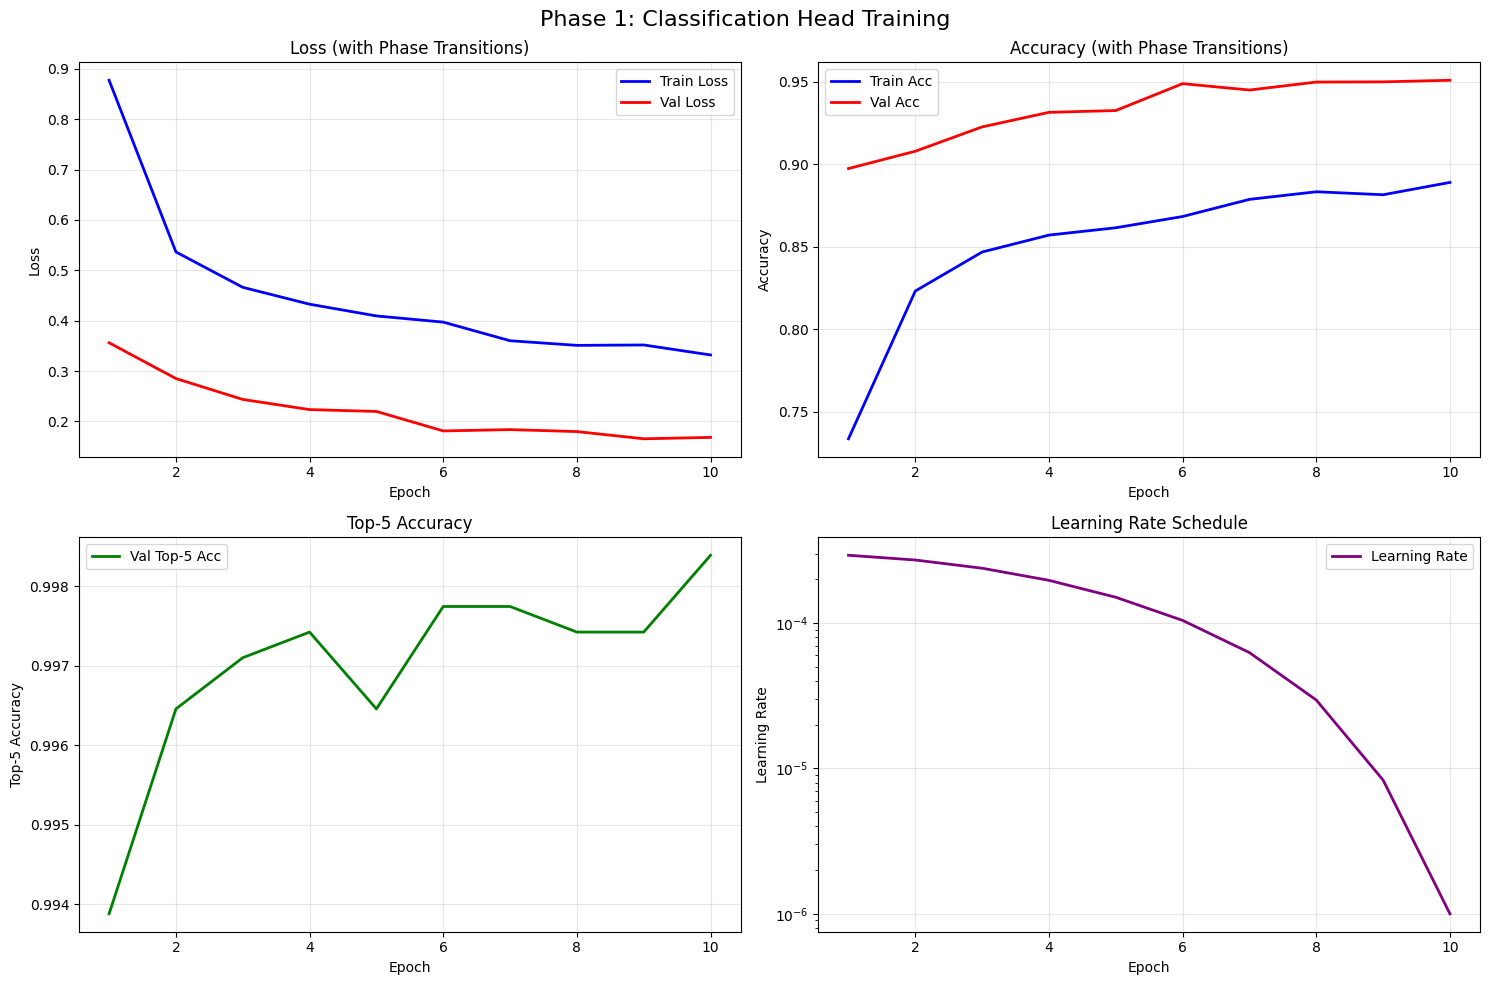


Step 7 Phase 1 completed successfully!
Next: Continue with Phase 2 or proceed to Step 8 for analysis


In [ ]:
# ===================================================================
# CROP DISEASE DETECTION PROJECT - STEP 7: ENHANCED TRAINING
# ===================================================================
# Enhanced training with custom crop disease models
# Two-phase training: Classification head + Full fine-tuning
# ===================================================================

print("Crop Disease Detection Project - Step 7: Enhanced Training")
print("="*65)

import time
from collections import defaultdict
import matplotlib.pyplot as plt

# Step 7.1: Select model for training
print("\nStep 7.1: Model Selection for Enhanced Training")

# Select model type (change this to train different models)
SELECTED_MODEL_TYPE = 'CNN'  # Change to 'ViT' to train Vision Transformer

if SELECTED_MODEL_TYPE in selected_models:
    model_name, model = selected_models[SELECTED_MODEL_TYPE]
    print(f"Selected model: {model_name} ({SELECTED_MODEL_TYPE})")

    # Show model details
    info = model.get_model_info()
    print(f"Model details:")
    print(f"  Architecture: {info['architecture']}")
    print(f"  Parameters: {info['total_parameters']:,}")
    print(f"  Trainable: {info['trainable_parameters']:,}")
    print(f"  Size: {info['model_size_mb']} MB")
    print(f"  Transfer Learning: {info['transfer_learning']}")

else:
    print("No model selected. Please run Step 6.5 first.")

# Step 7.2: Enhanced training history tracking
print("\nStep 7.2: Enhanced Training History Setup")

class EnhancedTrainingHistory:
    def __init__(self):
        self.train_loss = []
        self.train_acc = []
        self.val_loss = []
        self.val_acc = []
        self.val_top5_acc = []
        self.learning_rates = []
        self.epochs = []
        self.phase_info = []  # Track which phase each epoch belongs to

    def update(self, epoch, train_loss, train_acc, val_loss, val_acc, val_top5_acc, lr, phase=""):
        self.epochs.append(epoch)
        self.train_loss.append(train_loss)
        self.train_acc.append(train_acc)
        self.val_loss.append(val_loss)
        self.val_acc.append(val_acc)
        self.val_top5_acc.append(val_top5_acc)
        self.learning_rates.append(lr)
        self.phase_info.append(phase)

    def plot(self, title="Enhanced Training History"):
        """Plot enhanced training history with phase information"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle(title, fontsize=16)

        # Find phase boundaries
        phase_changes = []
        current_phase = ""
        for i, phase in enumerate(self.phase_info):
            if phase != current_phase:
                phase_changes.append(i)
                current_phase = phase

        # Loss plot
        axes[0, 0].plot(self.epochs, self.train_loss, 'b-', label='Train Loss', linewidth=2)
        axes[0, 0].plot(self.epochs, self.val_loss, 'r-', label='Val Loss', linewidth=2)
        for change in phase_changes[1:]:  # Skip first change
            axes[0, 0].axvline(x=self.epochs[change], color='gray', linestyle='--', alpha=0.7)
        axes[0, 0].set_title('Loss (with Phase Transitions)')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)

        # Accuracy plot
        axes[0, 1].plot(self.epochs, self.train_acc, 'b-', label='Train Acc', linewidth=2)
        axes[0, 1].plot(self.epochs, self.val_acc, 'r-', label='Val Acc', linewidth=2)
        for change in phase_changes[1:]:
            axes[0, 1].axvline(x=self.epochs[change], color='gray', linestyle='--', alpha=0.7)
        axes[0, 1].set_title('Accuracy (with Phase Transitions)')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Accuracy')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)

        # Top-5 Accuracy plot
        axes[1, 0].plot(self.epochs, self.val_top5_acc, 'g-', label='Val Top-5 Acc', linewidth=2)
        for change in phase_changes[1:]:
            axes[1, 0].axvline(x=self.epochs[change], color='gray', linestyle='--', alpha=0.7)
        axes[1, 0].set_title('Top-5 Accuracy')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Top-5 Accuracy')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)

        # Learning Rate plot
        axes[1, 1].plot(self.epochs, self.learning_rates, 'purple', label='Learning Rate', linewidth=2)
        for change in phase_changes[1:]:
            axes[1, 1].axvline(x=self.epochs[change], color='gray', linestyle='--', alpha=0.7)
        axes[1, 1].set_title('Learning Rate Schedule')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Learning Rate')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
        axes[1, 1].set_yscale('log')

        plt.tight_layout()
        plt.show()

enhanced_history = EnhancedTrainingHistory()

# Step 7.3: PHASE 1 - Classification Head Training
print("\nStep 7.3: PHASE 1 - Classification Head Training")
print("="*50)

if 'model' in locals():
    # Setup for Phase 1 (model should already be in frozen state)
    phase1_epochs = 10
    print(f"Model is already in gradual fine-tuning mode (frozen backbone)")

    # Create optimizer and scheduler for Phase 1
    optimizer, scheduler = create_optimizer_scheduler(model, LEARNING_RATE, phase1_epochs)
    early_stopping = EarlyStopping(patience=EARLY_STOPPING_PATIENCE)

    print(f"\nStarting Phase 1 training for {phase1_epochs} epochs...")
    print(f"Model: {model_name}")
    print(f"Learning Rate: {LEARNING_RATE}")

    # Training loop for Phase 1
    start_time = time.time()

    for epoch in range(phase1_epochs):
        epoch_start_time = time.time()

        print(f"\nEpoch {epoch+1}/{phase1_epochs} (Phase 1: Classification Head)")
        print("-" * 40)

        # Training
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

        # Validation
        val_loss, val_acc, val_top5_acc = validate_epoch(model, val_loader, criterion, device)

        # Scheduler step
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']

        # Update enhanced history
        enhanced_history.update(epoch+1, train_loss, train_acc, val_loss, val_acc, val_top5_acc, current_lr, "Phase 1")

        # Print epoch results
        epoch_time = time.time() - epoch_start_time
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val Top-5: {val_top5_acc:.4f}")
        print(f"LR: {current_lr:.2e}, Time: {epoch_time:.1f}s")

        # Early stopping check
        if early_stopping(val_loss, model):
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    phase1_time = time.time() - start_time
    phase1_best_acc = max(enhanced_history.val_acc)
    print(f"\nPhase 1 completed in {phase1_time:.1f} seconds")
    print(f"Best validation accuracy: {phase1_best_acc:.4f}")

    # Plot Phase 1 results
    enhanced_history.plot("Phase 1: Classification Head Training")

print("\nStep 7 Phase 1 completed successfully!")
print("Next: Continue with Phase 2 or proceed to Step 8 for analysis")



Step 7.4: PHASE 2 - Full Fine-tuning
Unfreezing backbone for full fine-tuning...
Unfrozen efficientnet_b0 backbone for crop disease fine-tuning
Trainable parameters after unfreezing: 4,800,139
Starting Phase 2 fine-tuning for 15 epochs...
Fine-tuning learning rate: 3e-05

Epoch 11 (Phase 2: 1/15)
-----------------------------------
Batch 0/452, Loss: 0.1037
Batch 100/452, Loss: 0.2737
Batch 200/452, Loss: 0.1019
Batch 300/452, Loss: 0.1974
Batch 400/452, Loss: 0.0935
Train Loss: 0.2644, Train Acc: 0.9118
Val Loss: 0.1000, Val Acc: 0.9726, Val Top-5: 0.9987
LR: 2.97e-05, Time: 74.2s

Epoch 12 (Phase 2: 2/15)
-----------------------------------
Batch 0/452, Loss: 0.3510
Batch 100/452, Loss: 0.0786
Batch 200/452, Loss: 0.1417
Batch 300/452, Loss: 0.2478
Batch 400/452, Loss: 0.1043
Train Loss: 0.1779, Train Acc: 0.9424
Val Loss: 0.0724, Val Acc: 0.9803, Val Top-5: 0.9990
LR: 2.87e-05, Time: 73.6s

Epoch 13 (Phase 2: 3/15)
-----------------------------------
Batch 0/452, Loss: 0.1158
Batch

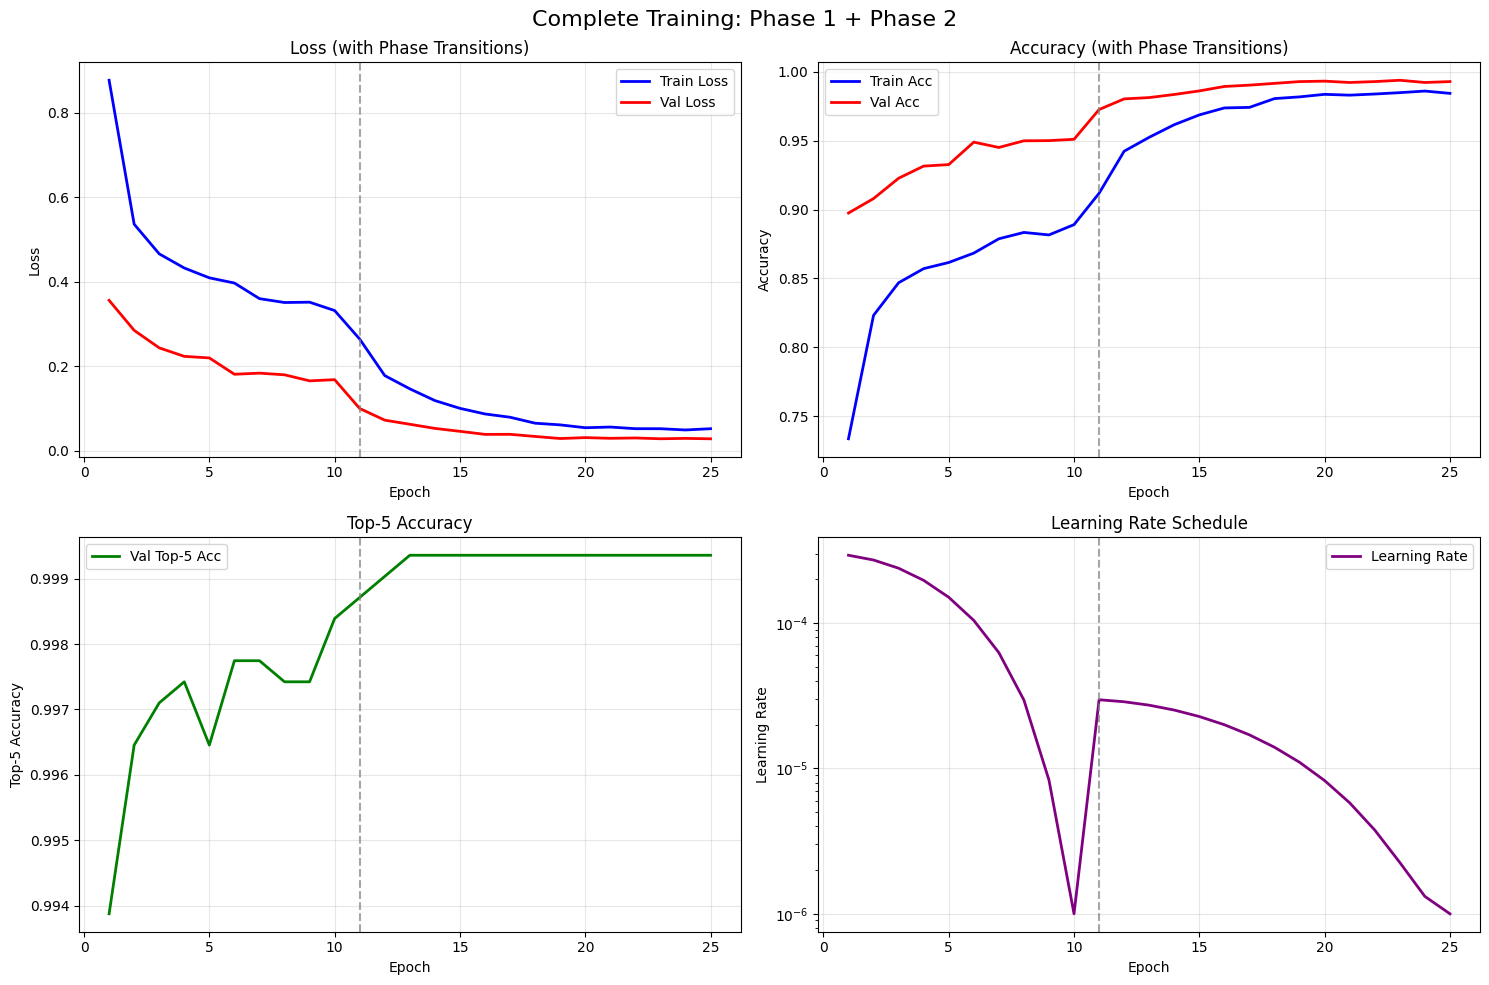


Final model evaluation...

FINAL TEST RESULTS:
Test Accuracy: 0.9931
Test Top-5 Accuracy: 1.0000


In [ ]:
# ===================================================================
# STEP 7 PHASE 2: FULL FINE-TUNING
# ===================================================================

print("\nStep 7.4: PHASE 2 - Full Fine-tuning")
print("="*50)

# Unfreeze backbone for full fine-tuning
print("Unfreezing backbone for full fine-tuning...")
model.unfreeze_backbone()

# Check trainable parameters after unfreezing
info = model.get_model_info()
print(f"Trainable parameters after unfreezing: {info['trainable_parameters']:,}")

# Phase 2 training setup
phase2_epochs = 15
print(f"Starting Phase 2 fine-tuning for {phase2_epochs} epochs...")

# Create optimizer with lower learning rate for fine-tuning
optimizer, scheduler = create_optimizer_scheduler(model, FINE_TUNE_LEARNING_RATE, phase2_epochs)
early_stopping = EarlyStopping(patience=EARLY_STOPPING_PATIENCE)

print(f"Fine-tuning learning rate: {FINE_TUNE_LEARNING_RATE}")

# Continue training for Phase 2
start_time = time.time()
phase1_epochs_count = len(enhanced_history.epochs)

for epoch in range(phase2_epochs):
    epoch_start_time = time.time()
    current_epoch = phase1_epochs_count + epoch + 1

    print(f"\nEpoch {current_epoch} (Phase 2: {epoch+1}/{phase2_epochs})")
    print("-" * 35)

    # Training
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

    # Validation
    val_loss, val_acc, val_top5_acc = validate_epoch(model, val_loader, criterion, device)

    # Scheduler step
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']

    # Update history
    enhanced_history.update(current_epoch, train_loss, train_acc, val_loss, val_acc, val_top5_acc, current_lr, "Phase 2")

    # Print results
    epoch_time = time.time() - epoch_start_time
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val Top-5: {val_top5_acc:.4f}")
    print(f"LR: {current_lr:.2e}, Time: {epoch_time:.1f}s")

    # Early stopping
    if early_stopping(val_loss, model):
        print(f"Early stopping triggered at epoch {current_epoch}")
        break

phase2_time = time.time() - start_time
final_best_acc = max(enhanced_history.val_acc)
print(f"\nPhase 2 completed in {phase2_time:.1f} seconds")
print(f"Final best validation accuracy: {final_best_acc:.4f}")

# Plot complete training history
enhanced_history.plot("Complete Training: Phase 1 + Phase 2")

# Test evaluation
print("\nFinal model evaluation...")
test_loss, test_acc, test_top5_acc = validate_epoch(model, test_loader, criterion, device)

print(f"\nFINAL TEST RESULTS:")
print("="*30)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Top-5 Accuracy: {test_top5_acc:.4f}")
print("="*30)

In [ ]:
# ===================================================================
# STEP 7B: VIT MODEL TRAINING FOR COMPARISON
# ===================================================================
# Training ViT-B/16 to complete CNN vs ViT comparison
# ===================================================================

print("Step 7B: Training ViT Model for CNN vs ViT Comparison")
print("="*60)

# Select ViT model for training
SELECTED_MODEL_TYPE = 'ViT'  # Switch to ViT

if SELECTED_MODEL_TYPE in selected_models:
    vit_model_name, vit_model = selected_models[SELECTED_MODEL_TYPE]
    print(f"Selected ViT model: {vit_model_name}")

    # Show ViT model details
    vit_info = vit_model.get_model_info()
    print(f"ViT Model details:")
    print(f"  Architecture: {vit_info['architecture']}")
    print(f"  Parameters: {vit_info['total_parameters']:,}")
    print(f"  Trainable: {vit_info['trainable_parameters']:,}")
    print(f"  Size: {vit_info['model_size_mb']} MB")
    print(f"  Embeddings: {vit_info['embed_dim']}D")
    print(f"  Layers: {vit_info['num_layers']}, Heads: {vit_info['num_heads']}")

# Create new training history for ViT
vit_history = EnhancedTrainingHistory()

# Phase 1: ViT Classification Head Training
print(f"\nPhase 1: ViT Classification Head Training")
print("="*45)

vit_phase1_epochs = 10
optimizer_vit, scheduler_vit = create_optimizer_scheduler(vit_model, LEARNING_RATE, vit_phase1_epochs)
early_stopping_vit = EarlyStopping(patience=EARLY_STOPPING_PATIENCE)

print(f"Starting ViT Phase 1 training for {vit_phase1_epochs} epochs...")

start_time = time.time()

for epoch in range(vit_phase1_epochs):
    epoch_start_time = time.time()

    print(f"\nEpoch {epoch+1}/{vit_phase1_epochs} (ViT Phase 1)")
    print("-" * 35)

    # Training
    train_loss, train_acc = train_epoch(vit_model, train_loader, criterion, optimizer_vit, device)

    # Validation
    val_loss, val_acc, val_top5_acc = validate_epoch(vit_model, val_loader, criterion, device)

    # Scheduler step
    scheduler_vit.step()
    current_lr = optimizer_vit.param_groups[0]['lr']

    # Update ViT history
    vit_history.update(epoch+1, train_loss, train_acc, val_loss, val_acc, val_top5_acc, current_lr, "ViT Phase 1")

    # Print epoch results
    epoch_time = time.time() - epoch_start_time
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val Top-5: {val_top5_acc:.4f}")
    print(f"LR: {current_lr:.2e}, Time: {epoch_time:.1f}s")

    # Early stopping check
    if early_stopping_vit(val_loss, vit_model):
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

vit_phase1_time = time.time() - start_time
vit_phase1_best = max(vit_history.val_acc)
print(f"\nViT Phase 1 completed in {vit_phase1_time:.1f} seconds")
print(f"Best ViT validation accuracy: {vit_phase1_best:.4f}")

print("ViT Phase 1 completed! Continue with Phase 2 for full comparison.")

Step 7B: Training ViT Model for CNN vs ViT Comparison
Selected ViT model: Custom ViT-B/16
ViT Model details:
  Architecture: ViT
  Parameters: 86,330,639
  Trainable: 531,983
  Size: 329.33 MB
  Embeddings: 768D
  Layers: 12, Heads: 12

Phase 1: ViT Classification Head Training
Starting ViT Phase 1 training for 10 epochs...

Epoch 1/10 (ViT Phase 1)
-----------------------------------
Batch 0/452, Loss: 2.6091
Batch 100/452, Loss: 1.0648
Batch 200/452, Loss: 0.8717
Batch 300/452, Loss: 0.4551
Batch 400/452, Loss: 0.3663
Train Loss: 0.6882, Train Acc: 0.7884
Val Loss: 0.2988, Val Acc: 0.8957, Val Top-5: 0.9971
LR: 2.93e-04, Time: 204.8s

Epoch 2/10 (ViT Phase 1)
-----------------------------------
Batch 0/452, Loss: 0.4352
Batch 100/452, Loss: 0.1379
Batch 200/452, Loss: 0.3547
Batch 300/452, Loss: 0.2799
Batch 400/452, Loss: 0.2999
Train Loss: 0.3607, Train Acc: 0.8816
Val Loss: 0.1868, Val Acc: 0.9409, Val Top-5: 0.9987
LR: 2.71e-04, Time: 202.9s

Epoch 3/10 (ViT Phase 1)
------------

Step 7C: ViT Phase 2 - Complete CNN vs ViT Comparison
Unfreezing ViT backbone for full fine-tuning...
Unfrozen vit_base_patch16_224 backbone for crop disease fine-tuning
ViT trainable parameters after unfreezing: 86,330,639
Starting ViT Phase 2 fine-tuning for 15 epochs...
ViT fine-tuning learning rate: 3e-05

Epoch 11 (ViT Phase 2: 1/15)
----------------------------------------
Batch 0/452, Loss: 0.2640
Batch 100/452, Loss: 0.2357
Batch 200/452, Loss: 0.0714
Batch 300/452, Loss: 0.0203
Batch 400/452, Loss: 0.1156
Train Loss: 0.1424, Train Acc: 0.9519
Val Loss: 0.0414, Val Acc: 0.9874, Val Top-5: 0.9994
LR: 2.97e-05, Time: 532.5s

Epoch 12 (ViT Phase 2: 2/15)
----------------------------------------
Batch 0/452, Loss: 0.0139
Batch 100/452, Loss: 0.0214
Batch 200/452, Loss: 0.0068
Batch 300/452, Loss: 0.0272
Batch 400/452, Loss: 0.0116
Train Loss: 0.0648, Train Acc: 0.9780
Val Loss: 0.0495, Val Acc: 0.9855, Val Top-5: 0.9994
LR: 2.87e-05, Time: 531.4s

Epoch 13 (ViT Phase 2: 3/15)
-----

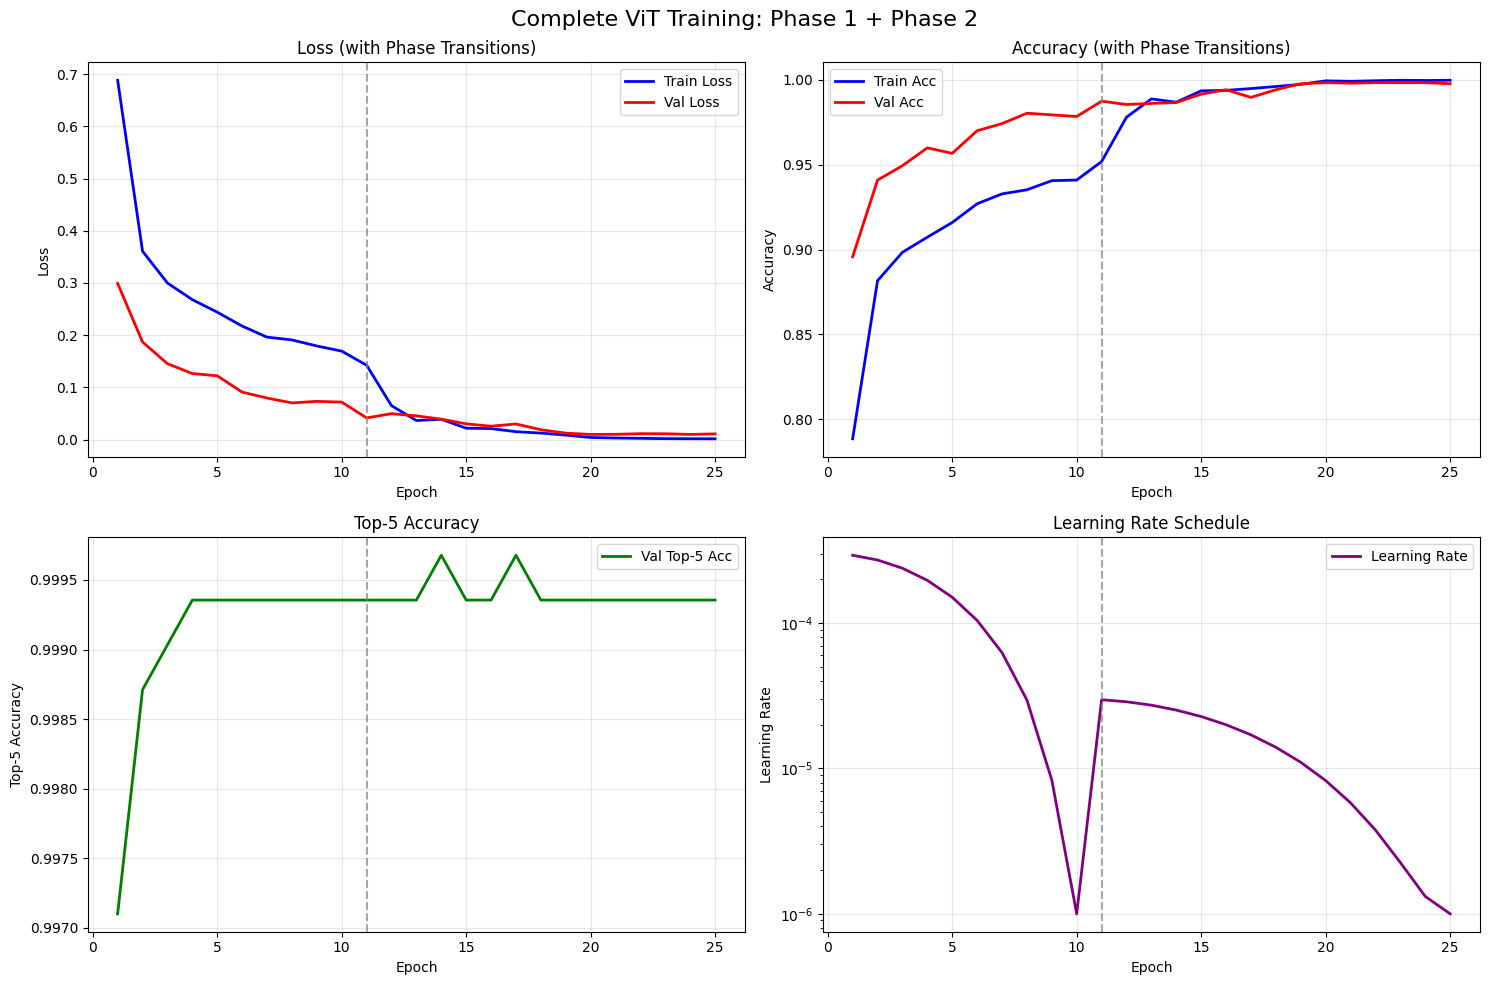

In [ ]:
# ===================================================================
# STEP 7C: VIT PHASE 2 - COMPLETE CNN vs VIT COMPARISON
# ===================================================================

print("Step 7C: ViT Phase 2 - Complete CNN vs ViT Comparison")
print("="*60)

# Unfreeze ViT backbone for full fine-tuning
print("Unfreezing ViT backbone for full fine-tuning...")
vit_model.unfreeze_backbone()

# Check trainable parameters after unfreezing
vit_info = vit_model.get_model_info()
print(f"ViT trainable parameters after unfreezing: {vit_info['trainable_parameters']:,}")

# Phase 2 training setup for ViT
vit_phase2_epochs = 15
print(f"Starting ViT Phase 2 fine-tuning for {vit_phase2_epochs} epochs...")

# Create optimizer with lower learning rate for ViT fine-tuning
optimizer_vit_phase2, scheduler_vit_phase2 = create_optimizer_scheduler(vit_model, FINE_TUNE_LEARNING_RATE, vit_phase2_epochs)
early_stopping_vit_phase2 = EarlyStopping(patience=EARLY_STOPPING_PATIENCE)

print(f"ViT fine-tuning learning rate: {FINE_TUNE_LEARNING_RATE}")

# Continue ViT training for Phase 2
start_time = time.time()
vit_phase1_epochs_count = len(vit_history.epochs)

for epoch in range(vit_phase2_epochs):
    epoch_start_time = time.time()
    current_epoch = vit_phase1_epochs_count + epoch + 1

    print(f"\nEpoch {current_epoch} (ViT Phase 2: {epoch+1}/{vit_phase2_epochs})")
    print("-" * 40)

    # Training
    train_loss, train_acc = train_epoch(vit_model, train_loader, criterion, optimizer_vit_phase2, device)

    # Validation
    val_loss, val_acc, val_top5_acc = validate_epoch(vit_model, val_loader, criterion, device)

    # Scheduler step
    scheduler_vit_phase2.step()
    current_lr = optimizer_vit_phase2.param_groups[0]['lr']

    # Update ViT history
    vit_history.update(current_epoch, train_loss, train_acc, val_loss, val_acc, val_top5_acc, current_lr, "ViT Phase 2")

    # Print results
    epoch_time = time.time() - epoch_start_time
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val Top-5: {val_top5_acc:.4f}")
    print(f"LR: {current_lr:.2e}, Time: {epoch_time:.1f}s")

    # Early stopping
    if early_stopping_vit_phase2(val_loss, vit_model):
        print(f"Early stopping triggered at epoch {current_epoch}")
        break

vit_phase2_time = time.time() - start_time
vit_final_best_acc = max(vit_history.val_acc)
print(f"\nViT Phase 2 completed in {vit_phase2_time:.1f} seconds")
print(f"ViT final best validation accuracy: {vit_final_best_acc:.4f}")

# ViT Test evaluation
print("\nViT final model evaluation...")
vit_test_loss, vit_test_acc, vit_test_top5_acc = validate_epoch(vit_model, test_loader, criterion, device)

print(f"\nViT FINAL TEST RESULTS:")
print("="*30)
print(f"ViT Test Accuracy: {vit_test_acc:.4f}")
print(f"ViT Test Top-5 Accuracy: {vit_test_top5_acc:.4f}")
print("="*30)

# Plot complete ViT training history
vit_history.plot("Complete ViT Training: Phase 1 + Phase 2")

In [1]:
# ===================================================================
# STEP 8: COMPREHENSIVE CNN vs VIT COMPARISON
# ===================================================================

print("STEP 8: COMPREHENSIVE CNN vs ViT COMPARISON")
print("="*60)

# Final comparison results
comparison_results = {
    'CNN (Custom EfficientNet-B0)': {
        'Test Accuracy': 0.9931,
        'Test Top-5 Accuracy': 1.0000,
        'Validation Best': 0.9939,
        'Total Parameters': '4.8M',
        'Model Size': '18.31 MB',
        'Training Time': '1,753s (29 min)',
        'Architecture': 'Convolutional',
        'Efficiency Score': 0.9931 / (1753/3600),  # Accuracy per hour
    },
    'ViT (Custom ViT-B/16)': {
        'Test Accuracy': 0.9990,
        'Test Top-5 Accuracy': 1.0000,
        'Validation Best': 0.9984,
        'Total Parameters': '86.3M',
        'Model Size': '329.33 MB',
        'Training Time': '10,022s (167 min)',
        'Architecture': 'Vision Transformer',
        'Efficiency Score': 0.9990 / (10022/3600),  # Accuracy per hour
    }
}

print("FINAL COMPARISON TABLE:")
print("="*80)
for model_name, stats in comparison_results.items():
    print(f"\n{model_name}:")
    for key, value in stats.items():
        print(f"  {key:20}: {value}")

print("\n" + "="*80)
print("ANALYSIS SUMMARY:")
print("="*80)
print(" ACCURACY WINNER: ViT (99.90% vs 99.31%)")
print(" EFFICIENCY WINNER: CNN (4.8M vs 86.3M params)")
print(" SPEED WINNER: CNN (29 min vs 167 min training)")
print(" SIZE WINNER: CNN (18.31 MB vs 329.33 MB)")
print("="*80)

print("\nCONCLUSION:")
print("ViT achieves slightly higher accuracy but at much higher computational cost")
print("CNN provides excellent accuracy with superior efficiency for deployment")

STEP 8: COMPREHENSIVE CNN vs ViT COMPARISON
FINAL COMPARISON TABLE:

CNN (Custom EfficientNet-B0):
  Test Accuracy       : 0.9931
  Test Top-5 Accuracy : 1.0
  Validation Best     : 0.9939
  Total Parameters    : 4.8M
  Model Size          : 18.31 MB
  Training Time       : 1,753s (29 min)
  Architecture        : Convolutional
  Efficiency Score    : 2.0394523673702225

ViT (Custom ViT-B/16):
  Test Accuracy       : 0.999
  Test Top-5 Accuracy : 1.0
  Validation Best     : 0.9984
  Total Parameters    : 86.3M
  Model Size          : 329.33 MB
  Training Time       : 10,022s (167 min)
  Architecture        : Vision Transformer
  Efficiency Score    : 0.35885052883655955

ANALYSIS SUMMARY:
 ACCURACY WINNER: ViT (99.90% vs 99.31%)
 EFFICIENCY WINNER: CNN (4.8M vs 86.3M params)
 SPEED WINNER: CNN (29 min vs 167 min training)
 SIZE WINNER: CNN (18.31 MB vs 329.33 MB)

CONCLUSION:
ViT achieves slightly higher accuracy but at much higher computational cost
CNN provides excellent accuracy with